1️⃣ Load & Inspect Data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/Fraud_Data.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


2️⃣ Data Cleaning (WITH JUSTIFICATION)


Missing Values

In [8]:
df.isna().sum()


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Duplicates

In [9]:
df.duplicated().sum()
df = df.drop_duplicates()


In [10]:
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])


3️⃣ Class Distribution (CRITICAL)

In [11]:
df['class'].value_counts()
df['class'].value_counts(normalize=True)


class
0    0.906354
1    0.093646
Name: proportion, dtype: float64

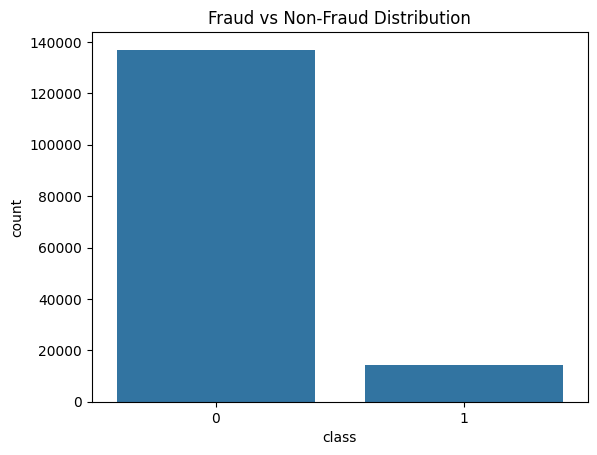

In [12]:
sns.countplot(x='class', data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()


4️⃣ Univariate Analysis

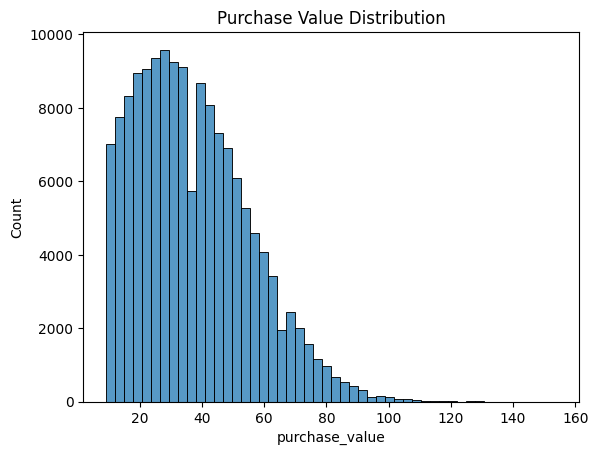

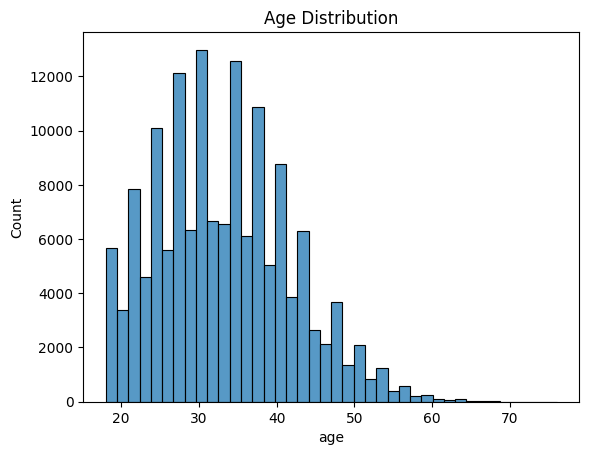

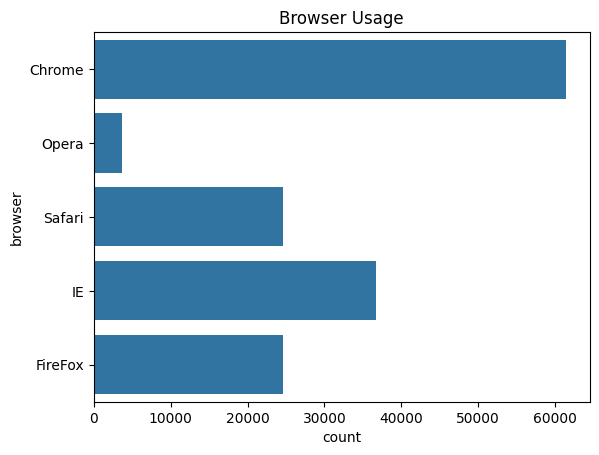

In [13]:
sns.histplot(df['purchase_value'], bins=50)
plt.title("Purchase Value Distribution")
plt.show()

sns.histplot(df['age'], bins=40)
plt.title("Age Distribution")
plt.show()

sns.countplot(y='browser', data=df)
plt.title("Browser Usage")
plt.show()


5️⃣ Bivariate Analysis (Fraud vs Features)

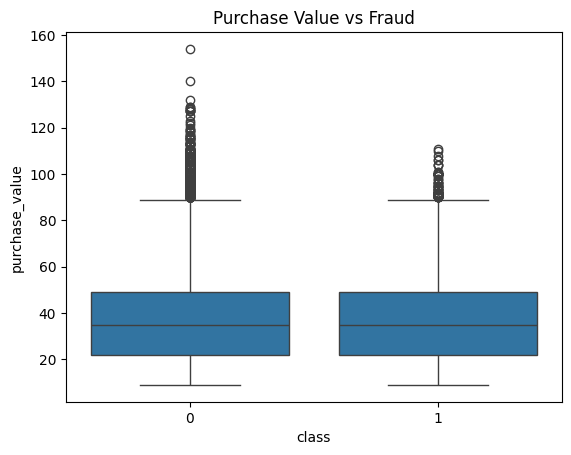

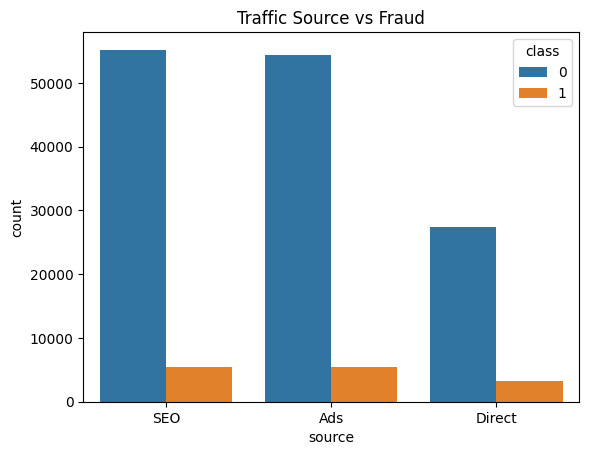

In [14]:
sns.boxplot(x='class', y='purchase_value', data=df)
plt.title("Purchase Value vs Fraud")
plt.show()

sns.countplot(x='source', hue='class', data=df)
plt.title("Traffic Source vs Fraud")
plt.show()


6️⃣ Convert IP Address Correctly (FLOAT → INT)

⚠️ Important: Your IPs are floats — we must cast safely.

In [15]:
import ipaddress

def ip_to_int_safe(ip):
    return int(ip)

df['ip_int'] = df['ip_address'].apply(ip_to_int_safe)


7️⃣ Load IP Mapping Table

In [16]:
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")

ip_df = ip_df.sort_values('lower_bound_ip_address')


8️⃣ Range-Based Merge (Correct & Efficient)

In [19]:
df['ip_int'].dtype
ip_df['lower_bound_ip_address'].dtype
ip_df['upper_bound_ip_address'].dtype


dtype('int64')

In [21]:
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype('int64')
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype('int64')


In [22]:
ip_df.dtypes


lower_bound_ip_address     int64
upper_bound_ip_address     int64
country                   object
dtype: object

In [23]:
df = pd.merge_asof(
    df,
    ip_df,
    left_on='ip_int',
    right_on='lower_bound_ip_address',
    direction='backward'
)


In [24]:
df = df[df['ip_int'] <= df['upper_bound_ip_address']]


In [25]:
df[['ip_address', 'ip_int', 'country']].head(10)
df['country'].isna().sum()


np.int64(0)

9️⃣ Fraud Analysis by Country

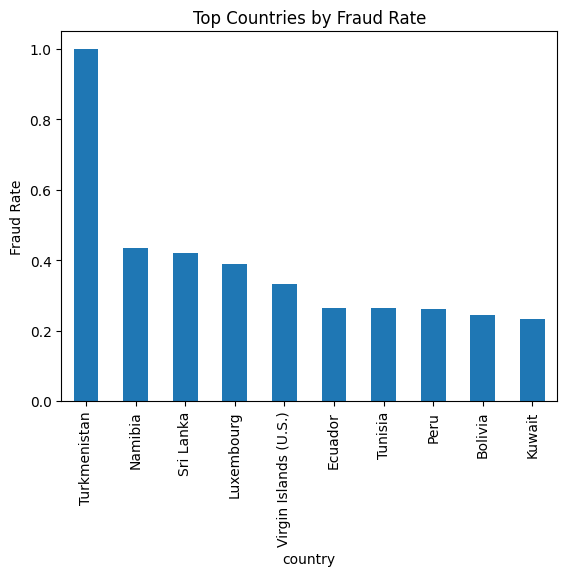

In [26]:
country_fraud = (
    df.groupby('country')['class']
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

country_fraud.plot(kind='bar')
plt.title("Top Countries by Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()


In [27]:
df['hour_of_day'] = df['purchase_time'].dt.hour
df['day_of_week'] = df['purchase_time'].dt.dayofweek

df['time_since_signup'] = (
    df['purchase_time'] - df['signup_time']
).dt.total_seconds() / 3600


In [30]:
# Ensure datetime
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# Sort and RESET index (THIS FIXES THE ERROR)
df = df.sort_values(['user_id', 'purchase_time']).reset_index(drop=True)

# Rolling transaction count in 24h window
tx_24h = (
    df
    .groupby('user_id')
    .rolling('24H', on='purchase_time')
    .purchase_time
    .count()
    .reset_index(level=0, drop=True)
)

# Assign safely
df['tx_count_24h'] = tx_24h.values


C:\Users\321\AppData\Local\Temp\ipykernel_7872\2838504437.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling('24H', on='purchase_time')
C:\Users\321\AppData\Local\Temp\ipykernel_7872\2838504437.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .purchase_time


In [31]:
from sklearn.preprocessing import StandardScaler

num_cols = [
    'purchase_value', 'age', 'time_since_signup', 'tx_count_24h'
]

cat_cols = ['source', 'browser', 'sex', 'country']

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [37]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[
    'class', 'signup_time', 'purchase_time', 'ip_address', 'ip_int'
])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [39]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_res.value_counts())


ImportError: cannot import name '_is_pandas_df' from 'sklearn.utils.validation' (c:\Users\321\Desktop\Kaleb\AI\Week5\fraud-detection\.venv\Lib\site-packages\sklearn\utils\validation.py)

In [ ]:
X_train_res.to_csv("../data/processed/X_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_train_res.to_csv("../data/processed/y_train.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)
